In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-housing-market/NY-House-Dataset.csv


In [2]:
df = pd.read_csv('/kaggle/input/new-york-housing-market/NY-House-Dataset.csv')
df

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.000000,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,Brokered by COMPASS,Co-op for sale,599000,1,1.000000,2184.207862,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879
4797,Brokered by Mjr Real Estate Llc,Co-op for sale,245000,1,1.000000,2184.207862,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152
4798,Brokered by Douglas Elliman - 575 Madison Ave,Co-op for sale,1275000,1,1.000000,2184.207862,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398
4799,Brokered by E Realty International Corp,Condo for sale,598125,2,1.000000,655.000000,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",New York,Queens County,Queens,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752


In [3]:

# Counting the number of distinct values in each column of the DataFrame
distinct_value_counts = {col: df[col].nunique() for col in df.columns}
distinct_value_counts

{'BROKERTITLE': 1036,
 'TYPE': 13,
 'PRICE': 1274,
 'BEDS': 27,
 'BATH': 22,
 'PROPERTYSQFT': 1445,
 'ADDRESS': 4582,
 'STATE': 308,
 'MAIN_ADDRESS': 4583,
 'ADMINISTRATIVE_AREA_LEVEL_2': 29,
 'LOCALITY': 11,
 'SUBLOCALITY': 21,
 'STREET_NAME': 174,
 'LONG_NAME': 2731,
 'FORMATTED_ADDRESS': 4550,
 'LATITUDE': 4196,
 'LONGITUDE': 4118}

In [4]:
unique_value_counts = {col: df[col].value_counts().head() for col in df.columns}
unique_value_counts

{'BROKERTITLE': BROKERTITLE
 Brokered by COMPASS                              456
 Brokered by Douglas Elliman - 575 Madison Ave    110
 Brokered by Brown Harris Stevens                  93
 Brokered by Corcoran East Side                    91
 Brokered by RE MAX Edge                           79
 Name: count, dtype: int64,
 'TYPE': TYPE
 Co-op for sale                1450
 House for sale                1012
 Condo for sale                 891
 Multi-family home for sale     727
 Townhouse for sale             299
 Name: count, dtype: int64,
 'PRICE': PRICE
 699000     53
 799000     48
 599000     47
 499000     42
 1250000    42
 Name: count, dtype: int64,
 'BEDS': BEDS
 3    1456
 2     995
 1     820
 4     570
 5     360
 Name: count, dtype: int64,
 'BATH': BATH
 2.000000    1671
 1.000000    1521
 4.000000     484
 3.000000     467
 2.373861     302
 Name: count, dtype: int64,
 'PROPERTYSQFT': PROPERTYSQFT
 2184.207862    1621
 800.000000       57
 900.000000       53
 750.000000

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['PRICE_standardized'] = scaler.fit_transform(df[['PRICE']])
sorted_df = df.sort_values(by='PRICE_standardized', ascending=False)
sorted_df = sorted_df[2:]
df = df.drop('BROKERTITLE', axis=1)

In [6]:
sorted_df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,PRICE_standardized
69,Brokered by Sotheby's International Realty - E...,Townhouse for sale,65000000,3,2.373861,15200.000000,4 E 79th St,"New York, NY 10075","4 E 79th StNew York, NY 10075",United States,New York,New York County,New York,East 79th Street,"4 E 79th St, New York, NY 10075, USA",40.776561,-73.963317,1.998057
1075,Brokered by COMPASS,Co-op for sale,60000000,8,8.000000,2184.207862,960 5th Ave Unit 12,"Manhattan, NY 10075","960 5th Ave Unit 12Manhattan, NY 10075",New York,New York County,New York,Manhattan,960,"960 5th Ave #12, New York, NY 10075, USA",40.775642,-73.964247,1.838578
141,Brokered by Douglas Elliman - 575 Madison Ave,House for sale,56000000,11,10.000000,24000.000000,9 W 54th St,"New York, NY 10019","9 W 54th StNew York, NY 10019",United States,New York,New York County,New York,West 54th Street,"9 W 54th St, New York, NY 10019, USA",40.761600,-73.976191,1.710994
99,Brokered by Douglas Elliman - 575 Madison Ave,House for sale,55000000,8,8.000000,12000.000000,25 Riverside Dr,"New York, NY 10023","25 Riverside DrNew York, NY 10023",United States,New York,New York County,New York,Riverside Drive,"25 Riverside Dr, New York, NY 10023, USA",40.782238,-73.984632,1.679098
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856,1.679098


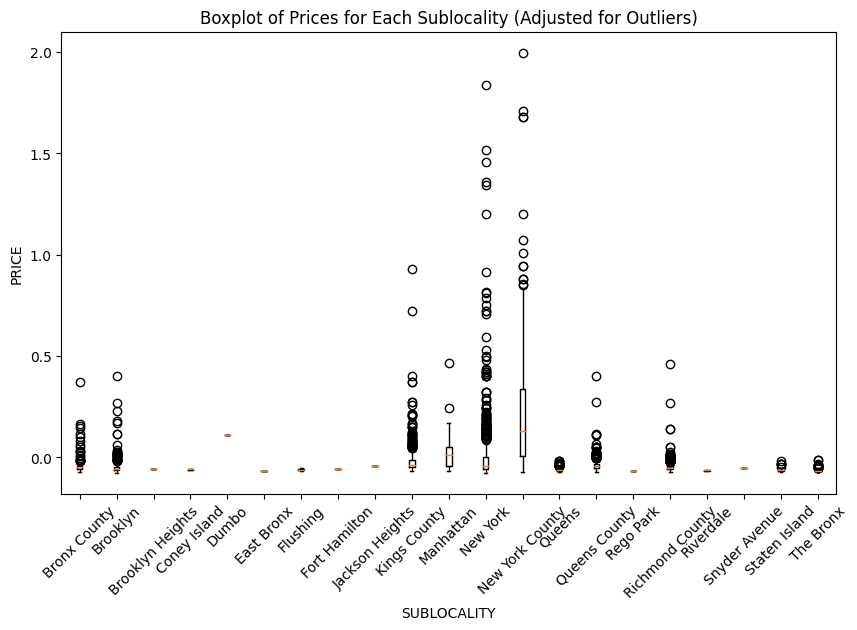

In [7]:
import matplotlib.pyplot as plt

grouped = sorted_df.groupby('SUBLOCALITY')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a list for x-tick labels
xticklabels = []
positions = []

for i, (name, group) in enumerate(grouped):
    # Adjust the 'whis' parameter here, e.g., 1.0, 1.5, etc.
    ax.boxplot(group['PRICE_standardized'], positions=[i], whis=1.5)

    xticklabels.append(name)
    positions.append(i)

# Set x-axis label
ax.set_xlabel('SUBLOCALITY')

# Set y-axis label
ax.set_ylabel('PRICE')

# Set x-tick labels
ax.set_xticks(positions)
ax.set_xticklabels(xticklabels, rotation=45)  # Rotate for better readability if needed

# Set title
ax.set_title('Boxplot of Prices for Each Sublocality (Adjusted for Outliers)')

# Show plot
plt.show()

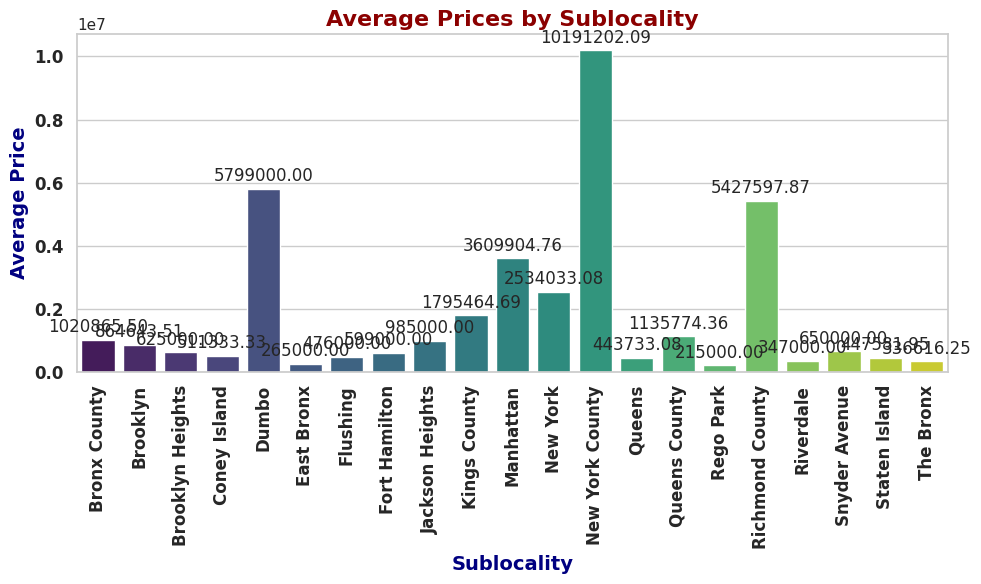

In [8]:
import seaborn as sns

average_prices = df.groupby('SUBLOCALITY')['PRICE'].mean()

# Using seaborn's style
sns.set(style="whitegrid")

# Plotting the average prices
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=average_prices.index, y=average_prices.values, palette="viridis")

# Adding labels and title with more customization
plt.xlabel('Sublocality', fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Average Price', fontsize=14, fontweight='bold', color='navy')
plt.title('Average Prices by Sublocality', fontsize=16, fontweight='bold', color='darkred')

# Customizing ticks for readability
plt.xticks(fontsize=12, fontweight='bold', rotation=90)
plt.yticks(fontsize=12, fontweight='bold')

# Adding value labels on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
label_encoder = LabelEncoder()
df['SUBLOCALITY_encoded'] = label_encoder.fit_transform(df['SUBLOCALITY'])
df
# Selecting the features (X) and the target (Y)
X = df[['SUBLOCALITY_encoded', 'PRICE', 'BEDS', 'BATH']]
Y = df['TYPE']

df.drop('PRICE', axis=1)

,TYPE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,PRICE_standardized,SUBLOCALITY_encoded
0,Condo for sale,2,2.000000,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,-0.065130,10
1,Condo for sale,7,10.000000,17545.000000,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991,6.144526,12
2,House for sale,4,2.000000,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,-0.066884,16
3,Condo for sale,3,1.000000,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,-0.072976,12
4,Townhouse for sale,7,2.373861,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856,1.679098,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,Co-op for sale,1,1.000000,2184.207862,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879,-0.056071,11
4797,Co-op for sale,1,1.000000,2184.207862,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152,-0.067362,14
4798,Co-op for sale,1,1.000000,2184.207862,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398,-0.034509,12
4799,Condo for sale,2,1.000000,655.000000,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",New York,Queens County,Queens,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752,-0.056099,13


In [10]:
Y.value_counts()

TYPE
Co-op for sale                1450
House for sale                1012
Condo for sale                 891
Multi-family home for sale     727
Townhouse for sale             299
Pending                        243
Contingent                      88
Land for sale                   49
For sale                        20
Foreclosure                     14
Condop for sale                  5
Coming Soon                      2
Mobile house for sale            1
Name: count, dtype: int64

In [11]:
X.head()

,SUBLOCALITY_encoded,PRICE,BEDS,BATH
0,10,315000,2,2.000000
1,12,195000000,7,10.000000
2,16,260000,4,2.000000
3,12,69000,3,1.000000
4,12,55000000,7,2.373861


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Accuracy: 0.5972944849115505


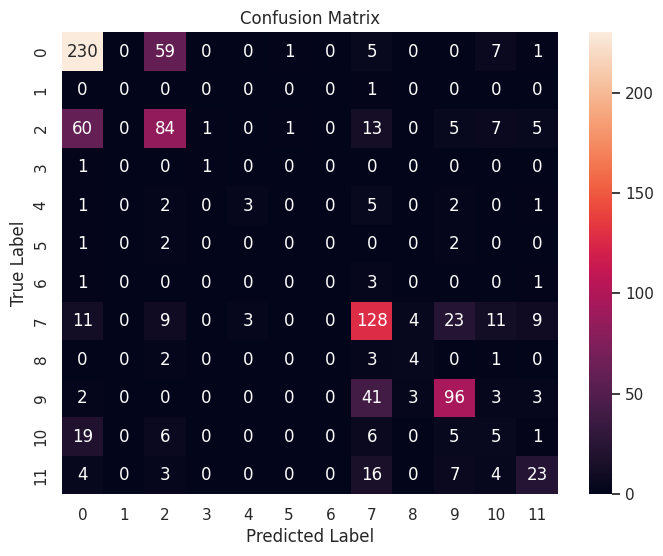

In [13]:
# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
df.columns

Index(['TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'ADDRESS', 'STATE',
       'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY',
       'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS',
       'LATITUDE', 'LONGITUDE', 'PRICE_standardized', 'SUBLOCALITY_encoded'],
      dtype='object')

In [15]:
columns_to_remove = ['ADDRESS', 'STATE', 'MAIN_ADDRESS', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS','PRICE_standardized','LATITUDE','LONGITUDE','SUBLOCALITY_encoded']
df_predict_price = df.drop(columns=columns_to_remove)
categorical_columns = ['ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'TYPE']

label_encoder = LabelEncoder()
for col in categorical_columns:
    df_predict_price[col] = label_encoder.fit_transform(df_predict_price[col])



df_predict_price.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY
0,2,315000,2,2.000000,1400.0,26,4,10
1,2,195000000,7,10.000000,17545.0,28,4,12
2,7,260000,4,2.000000,2015.0,28,4,16
3,2,69000,3,1.000000,445.0,28,4,12
4,12,55000000,7,2.373861,14175.0,28,4,12


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Splitting the data into features (X) and target variable (y)
X = df_predict_price.drop('PRICE', axis=1)
y = df_predict_price['PRICE']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error: 1008169.2548400671
Mean Squared Error: 15746603078728.916
R² Score: 0.3750066835271373


                       Feature  Importance
3                 PROPERTYSQFT    0.601807
2                         BATH    0.127388
1                         BEDS    0.090133
0                         TYPE    0.089681
6                  SUBLOCALITY    0.081758
4  ADMINISTRATIVE_AREA_LEVEL_2    0.007296
5                     LOCALITY    0.001938


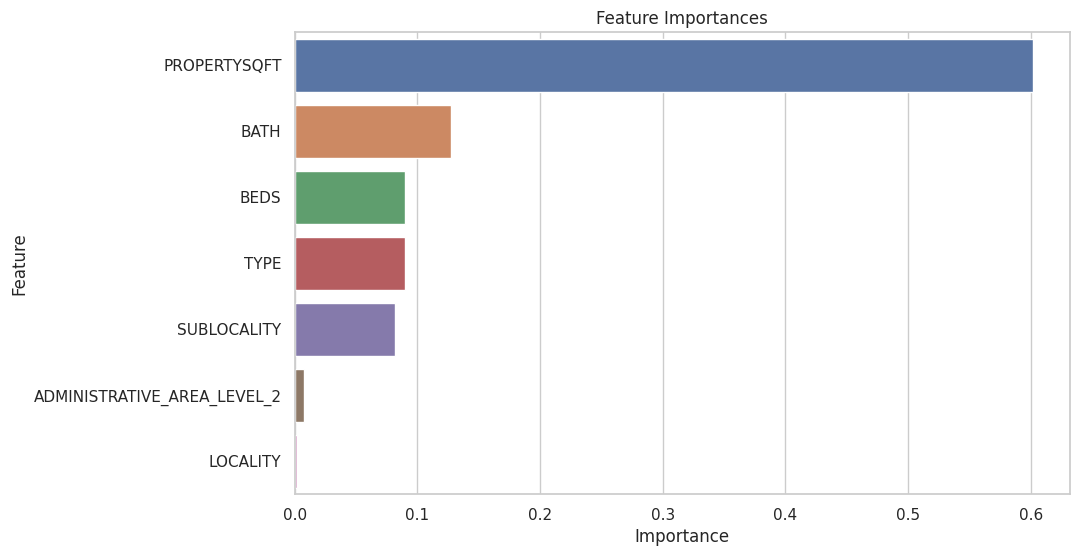

In [17]:
feature_importances = regressor.feature_importances_

# Creating a DataFrame to display feature importances
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance for better visualization
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(importances_df)

# Optional: Plotting the feature importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(random_state=42)

gb_regressor.fit(X_train, y_train)

y_pred_gb = gb_regressor.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Mean Absolute Error (Gradient Boosting): {mae_gb}")
print(f"Mean Squared Error (Gradient Boosting): {mse_gb}")
print(f"R² Score (Gradient Boosting): {r2_gb}")


Mean Absolute Error (Gradient Boosting): 1052559.8086847945
Mean Squared Error (Gradient Boosting): 11100579880052.764
R² Score (Gradient Boosting): 0.5594104836885152


In [19]:
from sklearn.preprocessing import StandardScaler

# Assuming df_predict_price is the DataFrame you're using and it's already encoded
# Selecting the numerical columns for scaling
numerical_columns = ['BEDS', 'BATH','PROPERTYSQFT']  # Adjust this list based on your actual numerical columns

# Initializing the scaler
scaler = StandardScaler()

# Applying the scaler to the numerical columns
df_predict_price[numerical_columns] = scaler.fit_transform(df_predict_price[numerical_columns])

df_predict_price.head()


,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY
0,2,315000,-0.521437,-0.192043,-0.329930,26,4,10
1,2,195000000,1.400130,3.917352,6.462550,28,4,12
2,7,260000,0.247190,-0.192043,-0.071189,28,4,16
3,2,69000,-0.137123,-0.705717,-0.731715,28,4,12
4,12,55000000,1.400130,0.000000,5.044733,28,4,12


In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df_predict_price.drop('PRICE', axis=1)
y = df_predict_price['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(gb_regressor, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best parameters:", grid_search.best_params_)

# Best Model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean Squared Error: 15302147245752.568
R² Score: 0.3926474358651977


In [21]:
gb_regressor = GradientBoostingRegressor(random_state=42)

gb_regressor.fit(X_train, y_train)

y_pred_gb = gb_regressor.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Mean Absolute Error (Gradient Boosting): {mae_gb}")
print(f"Mean Squared Error (Gradient Boosting): {mse_gb}")
print(f"R² Score (Gradient Boosting): {r2_gb}")


Mean Absolute Error (Gradient Boosting): 1052559.8086847945
Mean Squared Error (Gradient Boosting): 11100579880052.764
R² Score (Gradient Boosting): 0.5594104836885152
